## Objective

Detect the presence of certain job posting elements with a high degree of accuracy (>90%).
- part time option
- company benefits
- salary range

In [10]:
elements = [
    "part time option",
    "company benefit",
    "salary range"
    ]

In [11]:
# !pip install openai
# !pip install python-dotenv

In [12]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import openai
import os
from dotenv import load_dotenv

import time
from tqdm.notebook import tqdm as tqdm_notebook

In [13]:
openai.api_key =<ADD KEY HERE>

In [14]:
# import test data set
df = pd.read_csv('job_desc_examples.csv')

print(len(df))
df.head()

25


,job_desc,candidate requirements t,company benefits t,salary ranges t,part time options t,Unnamed: 5
0,With a unique legacy in dermatology as well as...,1,1,0,0,6708
1,"As a Technical Writer, you create clear and us...",0,0,0,0,1153
2,Refurbishment Manager Major Components (m/w/d)...,1,0,0,0,4762
3,Who We Are\n\nBCG X is the tech build & design...,1,1,1,0,4161
4,"Trade Sales Manager\n\nLOCATION: Madrid, Spain...",1,0,1,0,2221


## Approach: list and analyze

For this approach, we use the following two independent steps:
- we ask the LLM to extract and list the elements (part-time options, company benefits, salary) we are interested in
- we then ask the LLM to analyze the listed items and to once again determine if they can be classified as part-time option, company benefit or salary range.


### Step 1 - extract and list elements

In [15]:
# write a prompt template and a function which lists the elements in the job posting

def list_elements(job_desc, element):

  system_instruction = '''You are a bot which analyzes job descriptions.'''

  final_prompt = f'''Does the job description located between the triple hashtags below mention any {element}s?
  If yes, list maximum 3, using maximum 8 words for each. If no, write "no element detected"

  desired output format is a list:
  - {element} 1
  - {element} 2
  - {element} etc.


  ###
  {job_desc}
  ###
  '''

  # Make API call
  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      temperature=0,
      messages=[
          {"role": "system", "content": system_instruction},
          {"role": "user", "content": final_prompt}
      ]
  )
  message = response['choices'][0]['message']['content']
  # print(message)

  return message


In [16]:
job_desc = '''At least two years of professional experience in the field of machine learning, e.g., as a Data Scientist, Machine Learning Engineer, or Data Engineer.
Strong proficiency in Python and popular machine learning frameworks such as Scikit or TensorFlow / Keras.
Experience with agile project methods (Scrum, etc.)
Desirable experience in Natural Language Processing or in building recommender systems.
Enthusiasm for technology and an interest in technology consulting.
Completed university degree.
Very good German skills (at least C1 level) and good English skills.
The company offers an attractive starting salary and benefits dependent on experience.'''

element = 'part time options'
# element2 = 'company benefits'
# element3 = 'salary range'


# for element in elements:
list_elements(job_desc, element)

'no element detected'

### Step 2 - analyze elements

In [17]:
# write a function which analyzes the elements in the output from Step 1
def analyze_elements(message, element):

  system_instruction = '''You are a bot which analyzes lists.'''

  final_prompt = f'''Given the following phrases, please determine they include specific {element}s commonly found in a job postings.
  Respond with "1" if yes, "0" if no.

  ###
  {message}
  ###
  '''

  # Make API call
  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      temperature=0,
      messages=[
          {"role": "system", "content": system_instruction},
          {"role": "user", "content": final_prompt}
      ]
  )
  message = response['choices'][0]['message']['content']
  # print(message)

  return message


In [18]:
# test functions back-to-back
element = "part time option"
message = list_elements(job_desc, element)
analyze_elements(message, element)

'0'

In [19]:
# Create functions to enable application of extraction and analysis functions to pandas df

# extract elements for each row in df
def extract_for_row(row, element):
  time.sleep(1.5)
  return list_elements(row['job_desc'], element)

# analyze extracted output for each row in df
def analyze_for_row(row, col_name, element):
  time.sleep(1.5)
  return analyze_elements(row[col_name], element)

## Measure Performance

Here, we use the 25 manually collected job postings from Indeed to determine if the method is effective

In [20]:
# create function to check and display model accuracy
def check_and_display_accuracy(y_true, y_pred):

  # create confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()

  # Calculate accuracy and FPR
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  fp_rate = fp / (fp + tn)

  print(f'Accuracy: {accuracy}')
  print(f'FPR: {fp_rate}')

  # plot confusion matrix
  sns.set(font_scale=1.2)
  plt.figure(figsize=(6, 4))

  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')

  plt.show()


In [21]:
# main function which combines previous functions
def extract_and_analyze(element):

  # define column name which will hold extracted elements and predicted values
  col_name_ext = f'ext. {element}s'
  col_name_pred = f'{element}s p'
  col_name_true = f'{element}s t'     # this key must match the respective column name from the imported csv file

  # enable progress bar
  tqdm_notebook.pandas()

  # apply functions to df
  df[col_name_ext] = df.apply(extract_for_row, args=(element,), axis=1)
  df[col_name_pred] = df.apply(analyze_for_row, args=(col_name_ext, element,), axis=1)

  # Convert column with predicted values to integer type - this also checks whether API output has desired number format
  df[col_name_pred] = df[col_name_pred].astype(int)
  df[col_name_true] = df[col_name_true].astype(int)

  # create new df with relevant column from imported samples and predictions
  results_df = df[[col_name_ext, col_name_pred, col_name_true]]
  results_df.to_csv(f'{element} results.csv')   # write to disk in case API timeout occurs during loop

  check_and_display_accuracy(df[col_name_true], df[col_name_pred])

  # get rows where predictions are off
  filtered_df = results_df[results_df[col_name_true] != results_df[col_name_pred]]

 # display results
  display('ALL RESULTS', results_df, 'INCORRECT ROWS', filtered_df)


Accuracy: 0.96
FPR: 0.0


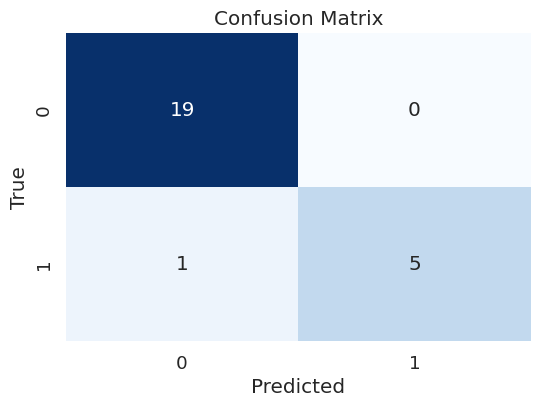

'ALL RESULTS'

,ext. part time options,part time options p,part time options t
0,no element detected,0,0
1,no element detected,0,0
2,no element detected,0,0
3,no element detected,0,0
4,no element detected,0,0
5,no element detected,0,0
6,no element detected,0,0
7,no element detected,0,1
8,no element detected,0,0
9,no element detected,0,0


'INCORRECT ROWS'

,ext. part time options,part time options p,part time options t
7,no element detected,0,1


Accuracy: 0.92
FPR: 0.2222222222222222


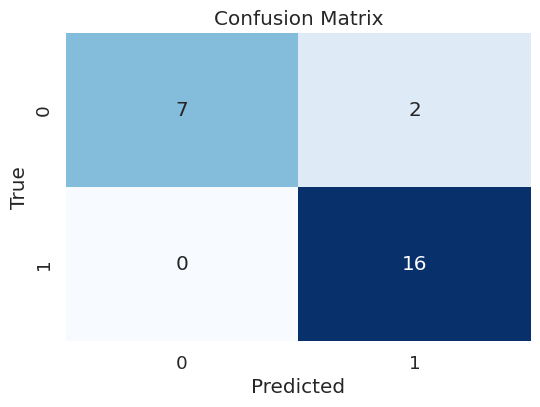

'ALL RESULTS'

,ext. company benefits,company benefits p,company benefits t
0,- Competitive and fair compensation with a bon...,1,1
1,- no element detected,0,0
2,- no element detected,0,0
3,"- Medical, dental and vision coverage\n- Gener...",1,1
4,- no element detected,0,0
5,- Travel expenses reimbursed and accommodation...,1,0
6,- Flexibilidad horaria\n- Programa de formació...,1,1
7,- A modern office including a rooftop terrace ...,1,1
8,- Extensive further training and customized de...,1,1
9,- Positive actions for social and business imp...,1,1


'INCORRECT ROWS'

,ext. company benefits,company benefits p,company benefits t
5,- Travel expenses reimbursed and accommodation...,1,0
20,- Young and stimulating work environment\n- Pa...,1,0


Accuracy: 1.0
FPR: 0.0


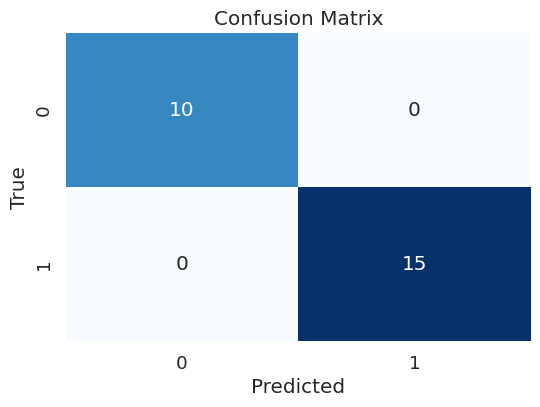

'ALL RESULTS'

,ext. salary ranges,salary ranges p,salary ranges t
0,no element detected,0,0
1,no element detected,0,0
2,no element detected,0,0
3,"- $110,000 USD (Data Scientist I)\n- $145,000 ...",1,1
4,"- Salary: From 70,000.00€ per year",1,1
5,"- Salary: 900.00€ - 1,500.00€ per week",1,1
6,"- 16.000,00€-16.500,00€ al año",1,1
7,"- Salary: Up to 64,000.00€ per year",1,1
8,"- Salary: 45,000.00€ - 51,000.00€ per year",1,1
9,no element detected,0,0


'INCORRECT ROWS'

,ext. salary ranges,salary ranges p,salary ranges t


In [22]:
# run analysis for each element
elements = [
    "part time option",
    "company benefit",
    "salary range"
    ]

for element in elements:
  extract_and_analyze(element)
  time.sleep(30)

In [23]:
# import results from disk function
def import_results(element):
  df = pd.read_csv(f'{element} results.csv')
  col_name_pred = f'{element}s p'
  col_name_true = f'{element}s t'
  col_name_ext = f'ext. {element}s'
  check_and_display_accuracy(df[col_name_true], df[col_name_pred])
  print("Average length of output:", df[col_name_ext].astype(str).apply(len).mean())
  display(df)

Accuracy: 0.96
FPR: 0.0


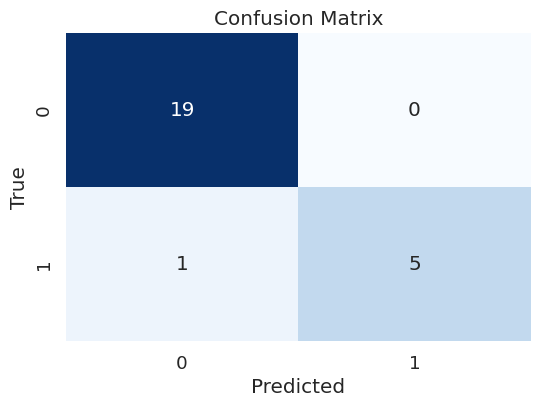

Average length of output: 27.08


,Unnamed: 0,ext. part time options,part time options p,part time options t
0,0,no element detected,0,0
1,1,no element detected,0,0
2,2,no element detected,0,0
3,3,no element detected,0,0
4,4,no element detected,0,0
5,5,no element detected,0,0
6,6,no element detected,0,0
7,7,no element detected,0,1
8,8,no element detected,0,0
9,9,no element detected,0,0


In [24]:
element = "part time option"
import_results(element)

Accuracy: 0.92
FPR: 0.2222222222222222


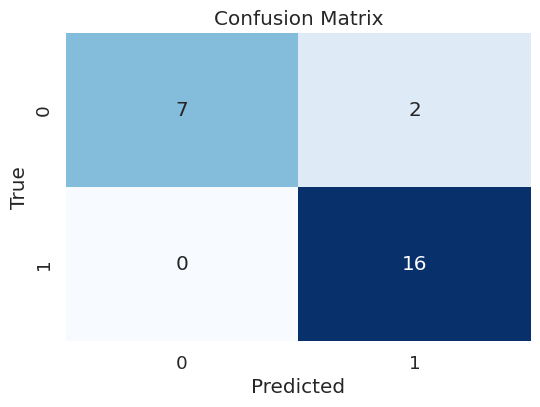

Average length of output: 109.08


,Unnamed: 0,ext. company benefits,company benefits p,company benefits t
0,0,- Competitive and fair compensation with a bon...,1,1
1,1,- no element detected,0,0
2,2,- no element detected,0,0
3,3,"- Medical, dental and vision coverage\n- Gener...",1,1
4,4,- no element detected,0,0
5,5,- Travel expenses reimbursed and accommodation...,1,0
6,6,- Flexibilidad horaria\n- Programa de formació...,1,1
7,7,- A modern office including a rooftop terrace ...,1,1
8,8,- Extensive further training and customized de...,1,1
9,9,- Positive actions for social and business imp...,1,1


In [25]:
element = "company benefit"
import_results(element)